# Setup
1. In colab: Go to "Runtime" -> "Change runtime type" -> Select "T4 GPU"
2. Install TerraTorch

In [ ]:
!pip install gdown tensorboard

In [2]:
import os
import sys
import torch
import gdown
import terratorch
import albumentations
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from pathlib import Path
from terratorch.datamodules import GenericNonGeoSegmentationDataModule
import warnings
warnings.filterwarnings('ignore')

3. Download the dataset from Google Drive

In [ ]:
if not os.path.isfile('hls_burn_scars.tar.gz'):
    gdown.download("https://drive.google.com/uc?id=1yFDNlGqGPxkc9lh9l1O70TuejXAQYYtC")

if not os.path.isdir('hls_burn_scars/'):
    !tar -xzvf hls_burn_scars.tar.gz


## HLS Burn Scars Dataset

Lets start with analyzing the dataset

In [4]:
dataset_path = Path('hls_burn_scars')
!ls "hls_burn_scars/"

data   splits


In [5]:
!ls "hls_burn_scars/data/" | head

subsetted_512x512_HLS.S30.T10SDH.2020248.v1.4.mask.tif
subsetted_512x512_HLS.S30.T10SDH.2020248.v1.4_merged.tif
subsetted_512x512_HLS.S30.T10SEH.2018190.v1.4.mask.tif
subsetted_512x512_HLS.S30.T10SEH.2018190.v1.4_merged.tif
subsetted_512x512_HLS.S30.T10SEH.2018245.v1.4.mask.tif
subsetted_512x512_HLS.S30.T10SEH.2018245.v1.4_merged.tif
subsetted_512x512_HLS.S30.T10SEH.2018280.v1.4.mask.tif
subsetted_512x512_HLS.S30.T10SEH.2018280.v1.4_merged.tif
subsetted_512x512_HLS.S30.T10SEH.2019305.v1.4.mask.tif
subsetted_512x512_HLS.S30.T10SEH.2019305.v1.4_merged.tif
ls: stdout: Undefined error: 0


In [6]:
datamodule = terratorch.datamodules.GenericNonGeoSegmentationDataModule(
    batch_size=4,
    num_workers=2,
    num_classes=2,

    # Define dataset paths 
    train_data_root=dataset_path / 'data/',
    train_label_data_root=dataset_path / 'data/',
    val_data_root=dataset_path / 'data/',
    val_label_data_root=dataset_path / 'data/',
    test_data_root=dataset_path / 'data/',
    test_label_data_root=dataset_path / 'data/',

    # Define splits
    train_split=dataset_path / 'splits/train.txt',
    val_split=dataset_path / 'splits/val.txt',
    test_split=dataset_path / 'splits/test.txt',
    
    img_grep='*_merged.tif',
    label_grep='*.mask.tif',
    
    train_transform=[
        albumentations.D4(), # Random flips and rotation
        albumentations.pytorch.transforms.ToTensorV2(),
    ],
    val_transform=None,  # Using ToTensor() by default
    test_transform=None,
        
    # Define standardization values
    means=[
      0.0333497067415863,
      0.0570118552053618,
      0.0588974813200132,
      0.2323245113436119,
      0.1972854853760658,
      0.1194491422518656,
    ],
    stds=[
      0.0226913556882377,
      0.0268075602230702,
      0.0400410984436278,
      0.0779173242367269,
      0.0870873883814014,
      0.0724197947743781,
    ],
    no_data_replace=0,
    no_label_replace=-1,
    # We use all six bands of the data, so we don't need to define dataset_bands and output_bands.
)

# Setup train and val datasets
datamodule.setup("fit")

In [7]:
# checking datasets train split size
train_dataset = datamodule.train_dataset
len(train_dataset)

524

In [8]:
# checking datasets validation split size
val_dataset = datamodule.val_dataset
len(val_dataset)

160

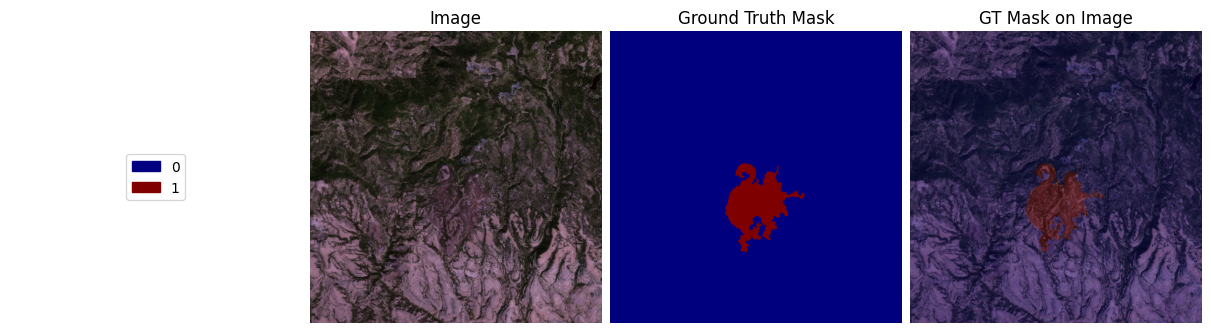

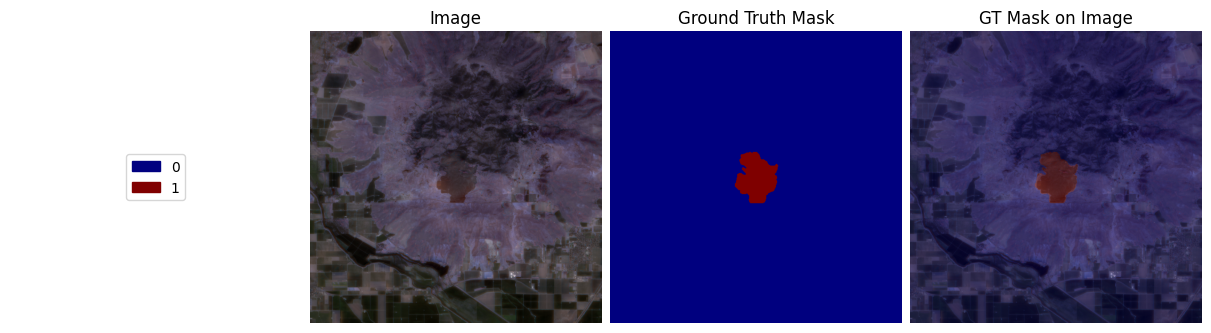

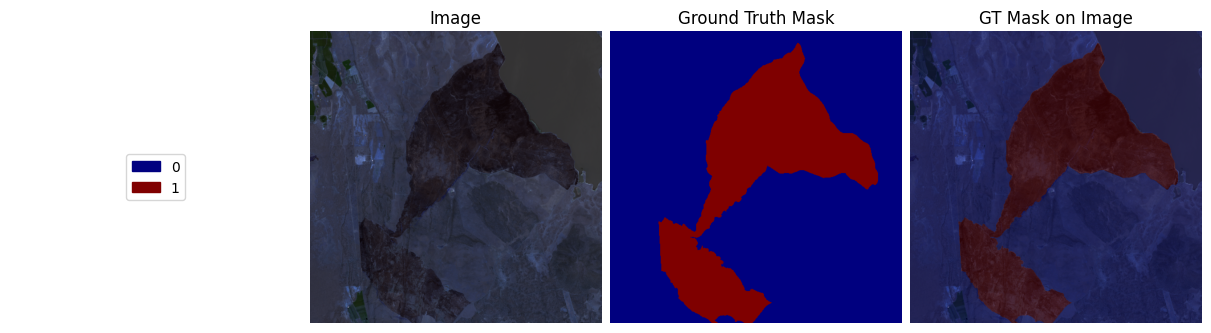

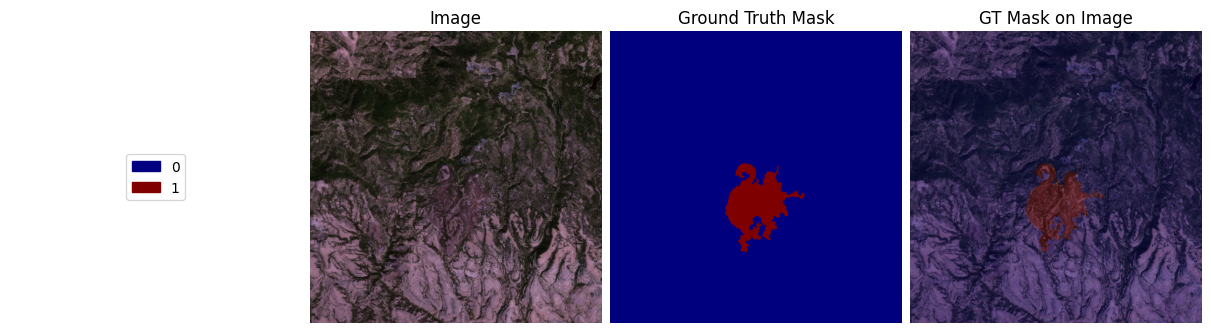

In [9]:
# plotting a few samples
val_dataset.plot(val_dataset[0])
val_dataset.plot(val_dataset[6])
val_dataset.plot(val_dataset[10])

In [10]:
# checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset
len(test_dataset)

120

# Fine-tune Prithvi

In [ ]:
from terratorch.tasks import SemanticSegmentationTask
pl.seed_everything(0)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="output/burnscars/checkpoints/",
    mode="max",
    monitor="val/Multiclass_Jaccard_Index", # Variable to monitor
    filename="best-{epoch:02d}",
)

# Lightning Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices=1, # Deactivate multi-gpu because it often fails in notebooks
    precision='bf16-mixed',  # Speed up training
    num_nodes=1,
    logger=True,  # Uses TensorBoard by default
    max_epochs=1, # For demos
    log_every_n_steps=1,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],
    default_root_dir="output/burnscars",
    detect_anomaly=True,
)

# Model
model = SemanticSegmentationTask(
    model_factory="EncoderDecoderFactory",
    model_args={
        # Backbone
        "backbone": "prithvi_eo_v2_300", # Model can be either prithvi_eo_v1_100, prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl
        "backbone_pretrained": True,
        "backbone_num_frames": 1, # 1 is the default value,
        "backbone_img_size": 512,
        "backbone_bands": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"],
        # "backbone_coords_encoding": [], # use ["time", "location"] for time and location metadata
        
        # Necks 
        "necks": [
            {
                "name": "SelectIndices",
                # "indices": [2, 5, 8, 11] # indices for prithvi_eo_v1_100
                "indices": [5, 11, 17, 23] # indices for prithvi_eo_v2_300
                # "indices": [7, 15, 23, 31] # indices for prithvi_eo_v2_600
            },
            {"name": "ReshapeTokensToImage",},
            {"name": "LearnedInterpolateToPyramidal"}            
        ],
        
        # Decoder
        "decoder": "UNetDecoder",
        "decoder_channels": [512, 256, 128, 64],
        
        # Head
        "head_dropout": 0.1,
        "num_classes": 2,
    },
    
    loss="ce",
    optimizer="AdamW",
    lr=1e-4,
    ignore_index=-1,
    freeze_backbone=True, # Only to speed up fine-tuning
    freeze_decoder=False,
    plot_on_val=True,
    class_names=['no burned', 'burned']  # optionally define class names
)

In [ ]:
# Training
trainer.fit(model, datamodule=datamodule)

In [ ]:
best_ckpt_path = "output/burnscars/checkpoints/best-epoch=00.ckpt"

In [ ]:
def run_test_and_visual_inspection(model,ckpt_path):

    # let's run the model on the test set
    trainer.test(model, datamodule=datamodule, ckpt_path=ckpt_path)

    # now we can use the model for predictions and plotting!
    model = terratorch.tasks.SemanticSegmentationTask.load_from_checkpoint(
        ckpt_path,
        model_factory=model.hparams.model_factory,
        model_args=model.hparams.model_args,
    )
    
    test_loader = datamodule.test_dataloader()
    
    with torch.no_grad():
        batch = next(iter(test_loader))
        images = datamodule.aug(batch)
        images = batch["image"].to(model.device)
        masks = batch["mask"].numpy()
    
        outputs = model(images)
        preds = torch.argmax(outputs.output, dim=1).cpu().numpy()
    
    for i in range(4):
        sample = {key: batch[key][i] for key in batch}
        sample["prediction"] = preds[i]
        sample["image"] = sample["image"].cpu()
        sample["mask"] = sample["mask"].cpu()
        test_dataset.plot(sample)

In [ ]:
run_test_and_visual_inspection(model, best_ckpt_path)

In [ ]:
best_ckpt_100_epoch_path = "burnscars_best-epoch=69.ckpt"

if not os.path.isfile(best_ckpt_100_epoch_path):
    gdown.download("https://drive.google.com/uc?id=1-I_DiiO2T1mjBTi3OAJaVeRWKHtAG63N")


In [ ]:
run_test_and_visual_inspection(model, best_ckpt_100_epoch_path)

# Fine-tuning via CLI

You might want to restart the session to free up GPU memory.

In [ ]:
# Run fine-tuning
!terratorch fit -c configs/prithvi_v2_eo_300_tl_unet_burnscars.yaml